<a href="https://colab.research.google.com/github/tmgrgg/nlp-mafiascum/blob/master/MafiaBaselineRNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!git clone https://bitbucket.org/bopjesvla/thesis.git

fatal: destination path 'thesis' already exists and is not an empty directory.


In [3]:
!mv thesis/src/* .

mv: cannot stat 'thesis/src/*': No such file or directory


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Pytorch


In [0]:
import numpy as np
import pandas as pd

In [6]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y
    def __len__(self):
        return len(self.y)

# Their Data loader

In [59]:
docs = pd.read_pickle('docs.pkl', compression='gzip')
print(docs.vector_FastText_wiki[0].shape)

(300,)


In [60]:
docs.head()

,game_id,author,content,inserted_at,updated_at,scum,slot_id,words,wc,punc,or_ratio,fpp_ratio,tpp_ratio,but_ratio,token_length,unique_tokens,message_count,message_length,sentence_length,time,wc24h,msg24h,vector_FastText_wiki,vector_GloVe_wiki200d,vector_GloVe_wiki,vector_GloVe_twitter,neg_ratio,neg_em_ratio,not_ratio,anger_ratio,sensory_ratio,cog_ratio,insight_ratio,motion_ratio,tent_ratio,spp_ratio,quant_ratio
0,28480,ThAdmiral,yep /!@ \nWhat if he is scum? This option woul...,2013-05-15 01:44:00,2013-07-22 00:17:00,False,240,"[yep, what, if, he, is, scum, this, option, wo...",2688,"[/!@, ?, ', ., :, ', ., /!@, ., ., ., /!@, (, ...",0.003348,0.042039,0.023065,0.006696,4.302455,0.221726,64,42.000000,0.087426,68.939583,38.990662,0.928349,"[-0.11273227513899668, 0.018551131866316774, -...","[0.16055721, 0.19409353, -0.09813492, -0.11749...","[-0.11783043, 0.09800706, -0.05116942, -0.0682...","[0.089912206, 0.19500107, 0.054465882, 0.10074...",0.018601,0.013393,0.018601,0.005952,0.017857,0.081101,0.024926,0.004836,0.029762,0.012649,0.013393
1,5845,Khelvaster,"[s]Gah...I don't know anyone. Vote: SPAG, sinc...",2007-08-02 16:33:00,2007-08-27 20:07:00,False,5210,"[s, gah, i, don, t, know, anyone, vote, spag, ...",863,"[[, ], ..., ', ., :, ,, ', .[/, ], ,, ', ..., ...",0.002317,0.042874,0.022016,0.005794,4.067207,0.403244,15,57.533333,0.092700,26.148611,33.003665,0.573644,"[-0.10023690888810728, 0.020833695785571843, -...","[0.14646702, 0.25892192, -0.08927924, -0.17455...","[-0.11812947, 0.10565025, -0.06426784, -0.1109...","[0.0961927, 0.19491331, 0.0321678, 0.071879774...",0.031286,0.006952,0.031286,0.001159,0.016222,0.077636,0.017381,0.006952,0.034762,0.027810,0.015064
2,30779,Elyse,/confirm /!@ ANNOUNCEMENT\nThere are NO jester...,2013-08-13 15:28:00,2013-10-11 00:52:00,False,447,"[confirm, announcement, there, are, no, jester...",3194,"[/, /!@, ,, ., ', !, /!@, ., :, /!@, ', /!@, '...",0.001252,0.051659,0.027239,0.008453,3.933626,0.229493,111,28.774775,0.130244,59.391667,53.778588,1.868949,"[-0.09363476607418539, 0.028349871196682513, -...","[0.17497152, 0.21025513, -0.10277278, -0.15136...","[-0.102921024, 0.0764547, -0.06794854, -0.0842...","[0.10085423, 0.16621116, 0.044601005, 0.105791...",0.033500,0.017533,0.033500,0.003444,0.028491,0.100188,0.027552,0.005322,0.022855,0.029430,0.011271
3,10744,Simpor,/confirm /!@ Vote: AWA\n\nFor being the last o...,2009-03-04 21:42:00,2009-03-14 21:23:00,True,6238,"[confirm, vote, awa, for, being, the, last, on...",154,"[/, /!@, :, .., /!@, ,, ?, !, /!@, ', ,, ., ',...",0.000000,0.064935,0.012987,0.006494,4.071429,0.649351,5,30.800000,0.103896,10.986806,14.016813,0.455091,"[-0.1328930663044335, 0.0116366885769277, -0.0...","[0.15854017, 0.26437867, -0.03646247, -0.20398...","[-0.16914089, 0.11391469, -0.057118926, -0.110...","[0.12944503, 0.13376419, 0.008241472, 0.091873...",0.025974,0.006494,0.025974,0.006494,0.012987,0.090909,0.019481,0.000000,0.032468,0.012987,0.038961
4,10617,blakebowling,"Confirm /!@ Vote: blakebowling /!@ Unvote, Vot...",2009-02-20 02:08:00,2009-03-01 03:10:00,False,6200,"[confirm, vote, blakebowling, unvote, vote, at...",239,"[/!@, :, /!@, ,, :, ., ', ., /!@, /!@, ,, .[/,...",0.000000,0.062762,0.004184,0.000000,3.928870,0.577406,12,19.916667,0.121339,10.043056,23.797538,1.194855,"[-0.11159829518160562, 0.030154899912205217, -...","[0.14067383, 0.29263738, -0.18649453, -0.12949...","[-0.089610584, 0.1020354, -0.11109041, -0.0602...","[0.17050445, 0.18049765, 0.07405566, -0.003876...",0.037657,0.025105,0.037657,0.008368,0.016736,0.050209,0.012552,0.020921,0.020921,0.016736,0.000000


In [61]:
# filter by wordcount to check that RNN works
docs['word_count'] = docs['words'].apply(lambda x: len(x))
docs = docs[docs['word_count'] < 500]
docs = docs[docs['word_count'] > 100]
docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1207 entries, 3 to 10368
Data columns (total 38 columns):
game_id                  1207 non-null int64
author                   1207 non-null object
content                  1207 non-null object
inserted_at              1207 non-null datetime64[ns]
updated_at               1207 non-null datetime64[ns]
scum                     1207 non-null bool
slot_id                  1207 non-null int64
words                    1207 non-null object
wc                       1207 non-null int64
punc                     1207 non-null object
or_ratio                 1207 non-null float64
fpp_ratio                1207 non-null float64
tpp_ratio                1207 non-null float64
but_ratio                1207 non-null float64
token_length             1207 non-null float64
unique_tokens            1207 non-null float64
message_count            1207 non-null int64
message_length           1207 non-null float64
sentence_length          1207 non-null float64


# RNN needs whole collection of FastText

In [62]:
if False:
  import gensim.downloader as api

  # care about subword info
  info = api.info()  # show info about available models/datasets
  wordmodel = api.load("fasttext-wiki-news-subwords-300")  # download the model and return as object ready for use
  wordmodel.save("drive/My Drive/fasttext.bin")
else:
  # don't care about subword info
  from gensim.models.keyedvectors import KeyedVectors
  wordmodel = KeyedVectors.load("drive/My Drive/fasttext.bin")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [63]:
wordmodel.most_similar("cat")

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cats', 0.8368596434593201),
 ('housecat', 0.7674711346626282),
 ('-cat', 0.7602992057800293),
 ('dog', 0.7502298355102539),
 ('kitten', 0.7480818033218384),
 ('feline', 0.7353992462158203),
 ('super-cat', 0.7305205464363098),
 ('supercat', 0.7163283824920654),
 ('pet', 0.7090284824371338),
 ('moggy', 0.7057286500930786)]

In [0]:
positive_weight = 1/len(docs[docs['scum'] == True])
negative_weight = 1/len(docs[docs['scum'] == False])

# Get Docs Vectors from FastText



In [0]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

class LossTracker():
  def __init__(self, plot_freq=5):
    self.counter = 0
    self.plot_freq = plot_freq
    self.loss_dict = {'train': [], 'val': []}

  def _make_plot(self):
      train_loss = self.loss_dict['train']
      val_loss = self.loss_dict['val']
      plt.plot(list(range(len(train_loss))), train_loss, c='blue', label='Train')
      plt.plot(list(range(len(val_loss))), val_loss, c='red', label='Val')
      plt.legend(loc='upper right')

  def plot(self):
    # will plot the current loss_graph every plot_freq^th call to plot
    self.counter += 1
    if (self.counter % self.plot_freq == 0):
      self._make_plot()
      clear_output()
      plt.show()
      plt.close()

  def save(self, path):
    # save the current loss_graph to the given path
    self._make_plot()
    plt.savefig(path)
    plt.close()

  def log(self, loss, setting='train'):
    # log/append loss values
    assert(setting == 'train' or setting == 'val')
    self.loss_dict[setting].append(loss)

In [0]:
# model will expect (seq_length, batch, features)

class BasicRNN(nn.Module):

  def __init__(self, hidden_size, word_model):
    super(BasicRNN, self).__init__()
    self.embedding_size = word_model.vectors.shape[1]
    self.hidden_size = hidden_size
    self.embedding = nn.Embedding.from_pretrained(torch.tensor(word_model.vectors))
    self.lstm = nn.LSTM(self.embedding_size, self.hidden_size)
    self.linear = nn.Linear(self.hidden_size, 2)

  def forward(self, ixs):
    seq_length = ixs.shape[1]
    batch_size = ixs.shape[0]

    h = (torch.randn(1, batch_size, self.hidden_size).to(device), torch.randn(1, batch_size, self.hidden_size).to(device))
    #h = h.to(device)
    x = self.embedding(ixs).view(seq_length, -1, self.embedding_size)
    x, h = self.lstm(x, h)
    return self.linear(h[1]).view(-1, 2)

### Train Basic Model!

In [0]:
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader

In [0]:
docs_list = list(docs.words.values)

In [68]:
# this will remove unknown words, which is probably undesirable (figure out how to use subword information)
docs_indexed = [[wordmodel.vocab[word].index for word in doc if word in wordmodel] for doc in docs_list]
#test:
print([wordmodel.index2word[index] for index in docs_indexed[0]])
# convert to vectors
docs_vectors = [torch.tensor(doc) for doc in docs_indexed]
print(docs_vectors[0])
ys = list(docs.scum.values)
ys = [torch.LongTensor([y]) for y in ys]
print(ys[3].shape, docs_vectors[3].shape)

['confirm', 'vote', 'awa', 'for', 'being', 'the', 'last', 'one', 'to', 'confirm', 'well', 'i', 'have', 'a', 'question', 'to', 'awa', 'your', 'planning', 'to', 'post', 'anything', 'soon', 'and', 'all', 'this', 'talk', 'about', 'cookies', 'makes', 'me', 'wanna', 'eat', 'some', 'i', 'think', 'that', 'af', 's', 'english', 'is', 'good', 'enough', 'at', 'least', 'the', 'two', 'last', 'posts', 'myself', 'i', 'm', 'from', 'sweden', 'so', 'english', 'is', 'not', 'my', 'first', 'language', 'and', 'i', 'have', 'sometimes', 'have', 'had', 'a', 'hard', 'time', 'explaining', 'my', 'intentions', 'however', 'i', 'should', 'not', 'be', 'treated', 'different', 'then', 'all', 'the', 'other', 'who', 'have', 'english', 'as', 'their', 'first', 'language', 'and', 'neither', 'should', 'af', 'if', 'you', 'want', 'a', 'tip', 'af', 'use', 'firefox', 'firefox', 'works', 'have', 'just', 'as', 'word', 'language', 'correction', 'mod', 'time', 'to', 'prod', 'awa', 'the', 'rules', 'don', 't', 'have', 'any', 'requireme

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(docs_vectors, ys, test_size=0.2, random_state=42)

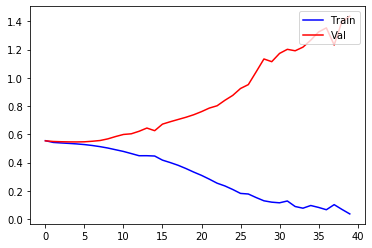

epoch 40 ::: Training Loss = 0.037, Validation Loss = 1.436
{'accuracy': 0.743801652892562, 'positives': 0.10330578512396695, 'negatives': 0.8966942148760331}


In [136]:
batch_size = 1
dataset_training = MyDataset(X_train, y_train)
dataloader = DataLoader(dataset_training, batch_size=batch_size)

dataset_test = MyDataset(X_test, y_test)
only_necessary_when_not_batching_dataloader = DataLoader(dataset_test, batch_size=batch_size)

num_epochs = 40

model = BasicRNN(64, wordmodel).to(device)

loss_function = nn.CrossEntropyLoss(weight=torch.Tensor([negative_weight, positive_weight]).cuda())
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)

losstracker = LossTracker(plot_freq=1)
for e in range(1, num_epochs + 1):
  epoch_loss = []
  i = 0
  for x, y in tqdm(dataloader):
      i += 1
      x = x.to(device)
      y = y.to(device)

      model.zero_grad()
      output = model(x)
      loss_train = loss_function(output, y.view(batch_size))
      loss_train.backward()
      optimizer.step()

      #print('epoch {}, batch {} ::: Training Loss = {:.3f}'.format(e, i, loss_train))
      epoch_loss.append(loss_train.item())

  # get mean training loss 
  loss_train = np.mean(epoch_loss)

  # get mean validation loss
  with torch.no_grad():
    validation_losses = []
    for x, y in only_necessary_when_not_batching_dataloader:
      x = x.to(device)
      y = y.to(device)
      output = model(x)
      loss_val = loss_function(output, y.view(batch_size)).item()
      validation_losses.append(loss_val)
    
    # get mean validation loss
    loss_val = np.mean(validation_losses)
  # track loss
  losstracker.log(loss_train, setting='train')
  losstracker.log(loss_val, setting='val')

  losstracker.plot()
  print('epoch {} ::: Training Loss = {:.3f}, Validation Loss = {:.3f}'.format(e, loss_train, loss_val))
  print(accuracy(model, X_test, y_test))

In [96]:
torch.softmax

<function _VariableFunctions.softmax>

In [0]:

### accuracy check
def accuracy(model, x_test, y_test):
  count = 0
  correct = 0
  positive = 0
  negative = 0
  with torch.no_grad():
    for i, x in enumerate(X_test):
      output = model(x.view(1, len(x)).cuda())
      sm = torch.softmax(output, dim=1)
      prediction = sm.argmax().item()
      if prediction == y_test[i]:
        correct += 1
      if prediction == 0:
        negative += 1
      if prediction == 1:
        positive += 1
      count += 1
  return {'accuracy': correct/count, 'positives': positive/count, 'negatives': negative/count}

In [120]:
accuracy(model, X_test, y_test)

{'accuracy': 0.22727272727272727,
 'negatives': 0.04132231404958678,
 'positives': 0.9586776859504132}

In [119]:
count = 0
positive = 0
for y in y_test:
  if y == 1:
    positive += 1
  count += 1
print(positive/count)

0.21074380165289255
